In [89]:
import pandas as pd
import ast
from matplotlib import pyplot as plt
import seaborn as sns
import re
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score


In [90]:
with open(r'steam_games.json') as file:

    data = []
    for line in file.readlines():
      
      data.append(ast.literal_eval(line))

data_steam = pd.DataFrame(data)


In [91]:
def drop_str(meta):
    if type(meta) == int or type(meta) == float:
        return meta

In [92]:
data_steam.metascore = data_steam.metascore.apply(drop_str)

In [93]:
def format_date(fecha):
    patron = r'^\d{4}-\d{2}-\d{2}$'
    
    return re.match(patron, str(fecha)) is not None

In [94]:
data_steam = data_steam[data_steam['release_date'].apply(format_date)]
data_steam.release_date = pd.to_datetime(data_steam.release_date).dt.year


In [95]:
def meta_value(valor):
    if isinstance(valor, str):
        return None
    else:
        return valor

In [96]:
data_steam.metascore = data_steam.metascore.apply(meta_value)


In [97]:
def price_game(price):
    if type(price)==float or type(price)==int:
        return price

In [98]:
data_steam=data_steam.loc[data_steam.price.apply(price_game).index]

In [99]:

data_steam = data_steam.loc[data_steam.price.apply(price_game).dropna().index]

In [100]:
data_steam.price = data_steam.price.astype(float)

In [101]:
def del_free(free):
    if 'free to play' not in str(free).lower():
        return free
    


In [102]:
data_steam = data_steam.loc[data_steam.genres.apply(del_free).dropna().index]

In [103]:
data_steam.metascore =data_steam.metascore.fillna(0)

In [104]:
data_steam

,publisher,genres,app_name,title,url,release_date,tags,discount_price,reviews_url,specs,price,early_access,id,developer,sentiment,metascore
0,Kotoshiro,"[Action, Casual, Indie, Simulation, Strategy]",Lost Summoner Kitty,Lost Summoner Kitty,http://store.steampowered.com/app/761140/Lost_...,2018,"[Strategy, Action, Indie, Casual, Simulation]",4.49,http://steamcommunity.com/app/761140/reviews/?...,[Single-player],4.99,False,761140,Kotoshiro,NaN,0.0
3,彼岸领域,"[Action, Adventure, Casual]",弹炸人2222,弹炸人2222,http://store.steampowered.com/app/767400/2222/,2017,"[Action, Adventure, Casual]",0.83,http://steamcommunity.com/app/767400/reviews/?...,[Single-player],0.99,False,767400,彼岸领域,NaN,0.0
5,Trickjump Games Ltd,"[Action, Adventure, Simulation]",Battle Royale Trainer,Battle Royale Trainer,http://store.steampowered.com/app/772540/Battl...,2018,"[Action, Adventure, Simulation, FPS, Shooter, ...",NaN,http://steamcommunity.com/app/772540/reviews/?...,"[Single-player, Steam Achievements]",3.99,False,772540,Trickjump Games Ltd,Mixed,0.0
12,Stegalosaurus Game Development,"[Action, Adventure, Casual, Indie, RPG]",Army of Tentacles: (Not) A Cthulhu Dating Sim:...,Army of Tentacles: (Not) A Cthulhu Dating Sim:...,http://store.steampowered.com/app/770380/Army_...,2018,"[Action, Adventure, RPG, Indie, Casual]",8.79,http://steamcommunity.com/app/770380/reviews/?...,"[Single-player, Steam Achievements]",10.99,False,770380,Stegalosaurus Game Development,NaN,0.0
13,Copperpick Studio,"[Casual, Indie]",Beach Rules,Beach Rules,http://store.steampowered.com/app/768880/Beach...,2018,"[Casual, Indie, Pixel Graphics, Cute, 2D]",NaN,http://steamcommunity.com/app/768880/reviews/?...,[Single-player],3.99,False,768880,Copperpick Studio,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32129,Bidoniera Games,"[Action, Adventure, Casual, Indie]",Kebab it Up!,Kebab it Up!,http://store.steampowered.com/app/745400/Kebab...,2018,"[Action, Indie, Casual, Violent, Adventure]",1.69,http://steamcommunity.com/app/745400/reviews/?...,"[Single-player, Steam Achievements, Steam Cloud]",1.99,False,745400,Bidoniera Games,2 user reviews,0.0
32130,Ghost_RUS Games,"[Casual, Indie, Simulation, Strategy]",Colony On Mars,Colony On Mars,http://store.steampowered.com/app/773640/Colon...,2018,"[Strategy, Indie, Casual, Simulation]",1.49,http://steamcommunity.com/app/773640/reviews/?...,"[Single-player, Steam Achievements]",1.99,False,773640,"Nikita ""Ghost_RUS""",NaN,0.0
32131,Sacada,"[Casual, Indie, Strategy]",LOGistICAL: South Africa,LOGistICAL: South Africa,http://store.steampowered.com/app/733530/LOGis...,2018,"[Strategy, Indie, Casual]",4.24,http://steamcommunity.com/app/733530/reviews/?...,"[Single-player, Steam Achievements, Steam Clou...",4.99,False,733530,Sacada,NaN,0.0
32132,Laush Studio,"[Indie, Racing, Simulation]",Russian Roads,Russian Roads,http://store.steampowered.com/app/610660/Russi...,2018,"[Indie, Simulation, Racing]",1.39,http://steamcommunity.com/app/610660/reviews/?...,"[Single-player, Steam Achievements, Steam Trad...",1.99,False,610660,Laush Dmitriy Sergeevich,NaN,0.0


In [105]:
data_steam.drop(columns=['publisher','app_name','title','url','discount_price','reviews_url','developer','sentiment','id', 'tags'],inplace=True)

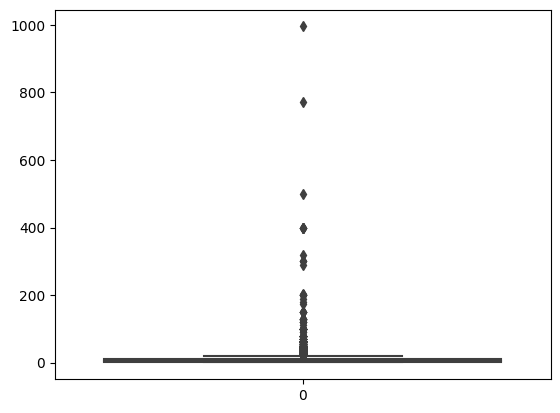

In [106]:
sns.boxplot(data_steam.price)
plt.show()

<__array_function__ internals>:180: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


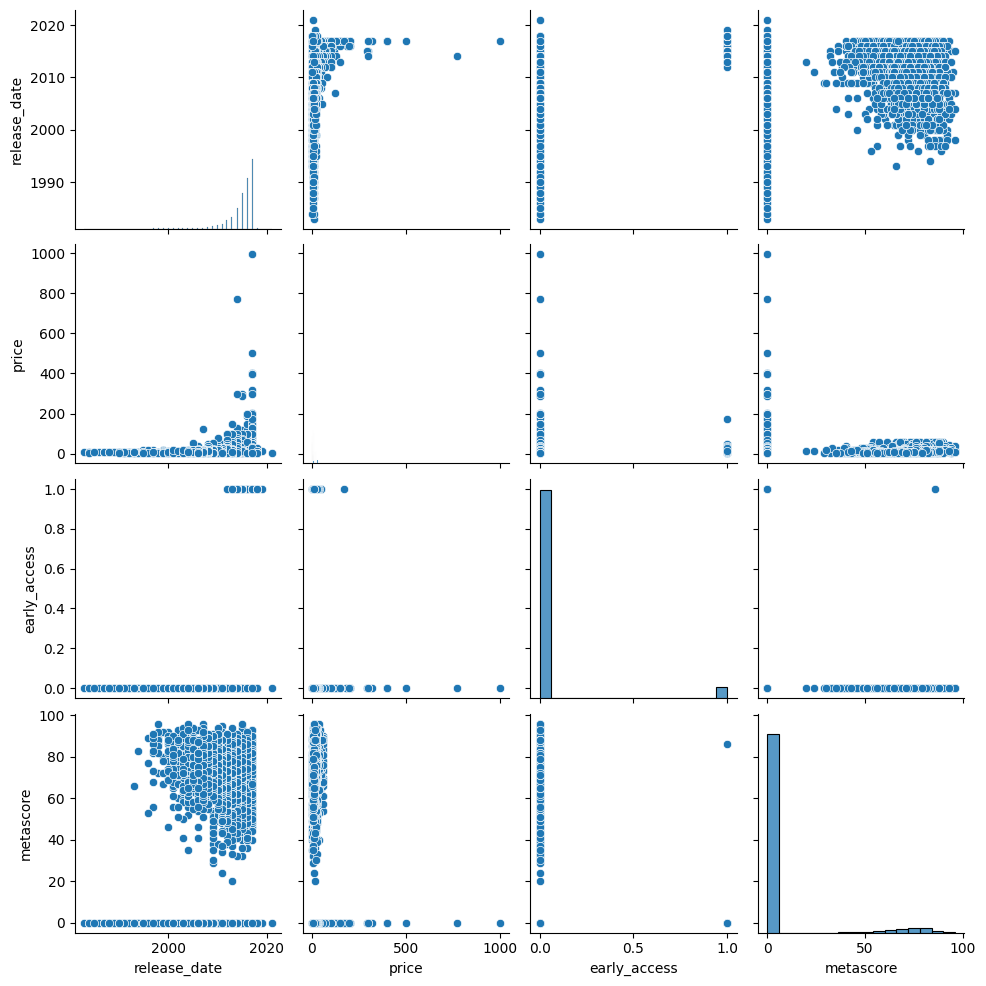

In [107]:
sns.pairplot(data_steam)
plt.show()

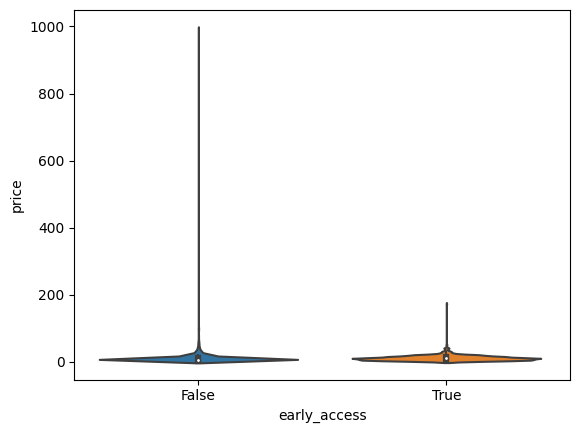

In [108]:
sns.violinplot(x='early_access',y='price',data=data_steam,split=True)
plt.show()

In [109]:
data_steam=data_steam.loc[data_steam.price.apply(price_game).index]

In [110]:
Q1  = data_steam.price.quantile(0.25)
Q3  = data_steam.price.quantile(0.75)

IQR = Q3-Q1

BI_Cal = (Q1-1.5*IQR)
BS_Cal = (Q3+1.5*IQR)

print(BI_Cal, BS_Cal,data_steam.price.size)
print(data_steam.query('price>@BI_Cal and price<@BS_Cal').price.size)

-7.51 20.490000000000002 25009
23540


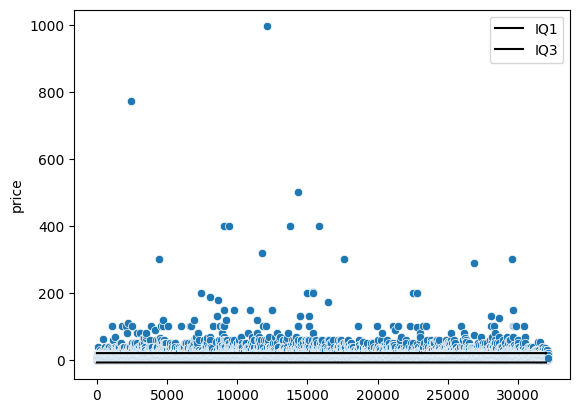

In [111]:
sns.scatterplot(data_steam.price)
plt.plot([x for x in range(32000)],[BS_Cal for x in range(32000)], color='black', label='IQ1')
plt.plot([x for x in range(32000)],[BI_Cal for x in range(32000)], color='black',label='IQ3')
plt.legend()
plt.show()

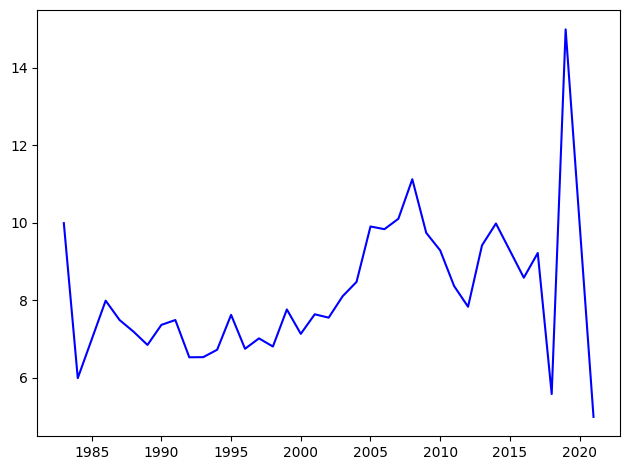

In [112]:
data_grouped = data_steam.groupby('release_date')['price'].mean().reset_index()

plt.plot(data_grouped['release_date'], data_grouped['price'], color='blue')
plt.tight_layout()
plt.show()


In [113]:
data_steam.price = data_steam.query('price>@BI_Cal and price<@BS_Cal').price.dropna()


0.31423560854208343


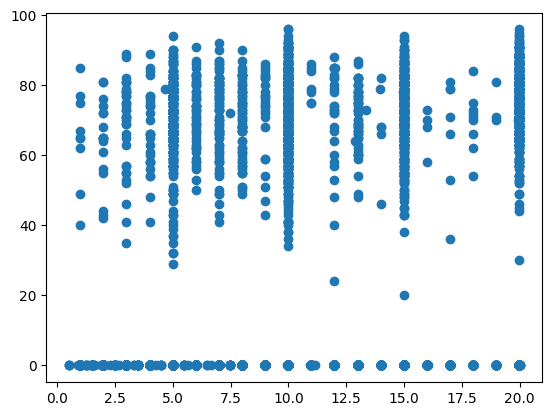

In [114]:
print(data_steam.loc[data_steam.metascore.dropna().index]['price'].corr(data_steam.loc[data_steam.metascore.dropna().index]['metascore']))
plt.scatter(data_steam.loc[data_steam.metascore.dropna().index]['price'],data_steam.loc[data_steam.metascore.dropna().index]['metascore'])
plt.show()

In [115]:
def unic_gen(genre):
    
    if type(genre) != float:
        return genre


In [116]:
def unic_pr(genre):
    return len(genre)

In [117]:
data_steam = data_steam.loc[data_steam.genres.dropna().apply(unic_gen).index]
data_steam = data_steam.loc[data_steam.specs.dropna().apply(unic_gen).index]

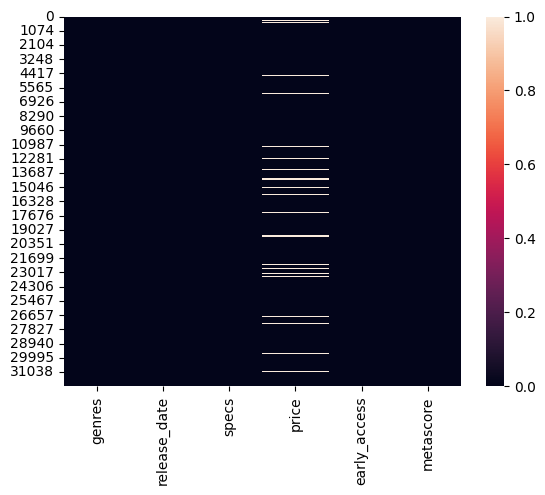

In [118]:
sns.heatmap(data_steam.isnull())
plt.show()

In [119]:
expanded_genres = data_steam['genres'].apply(pd.Series)
expanded_specs = data_steam['specs'].apply(pd.Series)

one_hot_genres = pd.get_dummies(expanded_genres, prefix='', prefix_sep='').groupby(level=0, axis=1).sum()
one_hot_specs = pd.get_dummies(expanded_specs, prefix='', prefix_sep='').groupby(level=0, axis=1).sum()

data_steam.drop(columns='genres', inplace=True)
data_steam.drop(columns='specs', inplace=True)

data_steam= pd.concat([data_steam,one_hot_genres],axis=1)
data_steam= pd.concat([data_steam,one_hot_specs],axis=1)

In [120]:
data_steam.price.fillna(data_steam.price.mean(), inplace=True)

In [121]:
data_steam.info()

<class 'pandas.core.frame.DataFrame'>
Index: 24748 entries, 0 to 32133
Data columns (total 52 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   release_date                24748 non-null  int32  
 1   price                       24748 non-null  float64
 2   early_access                24748 non-null  bool   
 3   metascore                   24748 non-null  float64
 4   Action                      24748 non-null  int64  
 5   Adventure                   24748 non-null  int64  
 6   Animation &amp; Modeling    24748 non-null  int64  
 7   Audio Production            24748 non-null  int64  
 8   Casual                      24748 non-null  int64  
 9   Design &amp; Illustration   24748 non-null  int64  
 10  Early Access                24748 non-null  int64  
 11  Education                   24748 non-null  int64  
 12  Indie                       24748 non-null  int64  
 13  Massively Multiplayer       24748 no

In [122]:
X = data_steam.drop(columns=['price'])
Y = data_steam['price']

X_Train, X_Test, Y_Train, Y_Test = train_test_split(X, Y, test_size = 0.25, random_state=0)

In [123]:
multi_regress = LinearRegression()
trained_regress= multi_regress.fit(X_Train, Y_Train)

Y_Pred = trained_regress.predict(X_Test)

In [124]:

rmse = mean_squared_error(Y_Test, Y_Pred, squared=False)
r2 = r2_score(Y_Test, Y_Pred)

print("Error Cuadrático Medio (RMSE):", rmse)

print("R2 score:", r2)

Error Cuadrático Medio (RMSE): 4.461942360459864
R2 score: 0.23905599059335736
